# 01. Preparing Notebook
# 02. Subsetting, Wrangling
# 03. Time-series analysis: decomposition
# 04. Testing for stationarity
# 05. Stationarizing Inflation Data
# 06. Bonus Task: Forecast
## 06a. Defining parameters
## 06b. Splitting data of difference
## 06c. Running and Fitting the Model
## 06d. Iterations
## 06e. Defining parameters
## 06f. Splitting data without difference
## 06g. Running and Fitting the Model
# 07. Lets try a second difference

## 01. Preparing Notebook

In [1]:
# importing libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm

import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight') 

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'FNC7ifBp54ZnP8tYP4RM'

In [3]:
# Importing Inflation Data for Germany

data = quandl.get('RATEINF/INFLATION_DEU')

In [4]:
data

,Value
Date,
1992-01-31,5.7
1992-02-29,5.8
1992-03-31,6.2
1992-04-30,6.2
1992-05-31,6.2
...,...
2022-01-31,4.9
2022-02-28,5.1
2022-03-31,7.3


#### There seems to be forcasted data in dataset.

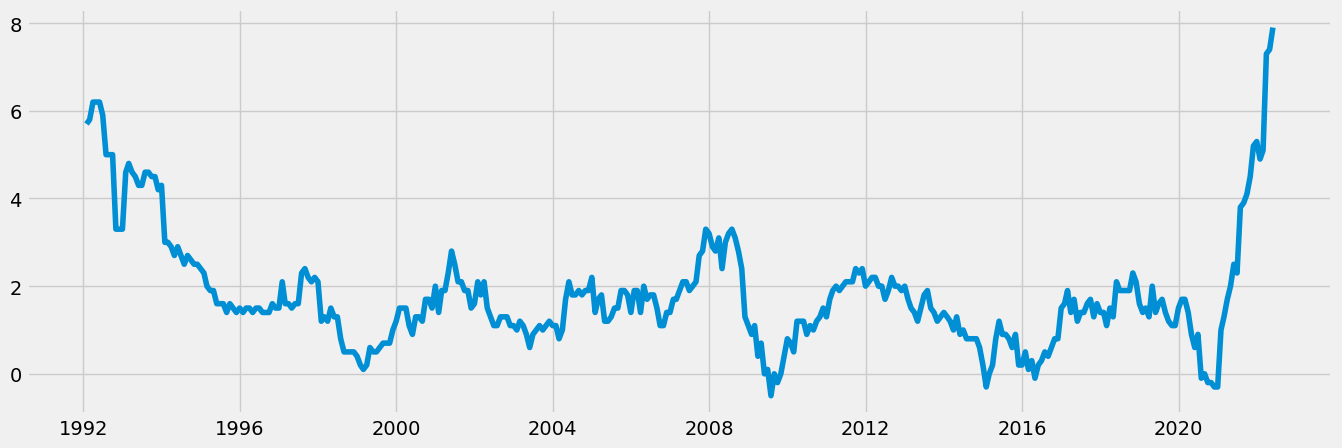

In [6]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

## 02. Subsetting, Wrangling

#### Subsetting data makes sense. Because right now we are in a very different situation than the time before and if I would forcast the inflation rate it will be probably completly wrong. Therefore I will drop every data after 31.12.2019 to keep the pandemic out of the way.

In [7]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [8]:
data_2.head()

,Date,Value
0,1992-01-31,5.7
1,1992-02-29,5.8
2,1992-03-31,6.2
3,1992-04-30,6.2
4,1992-05-31,6.2


In [9]:
data_sub = data_2.loc[(data_2['Date'] >= '1992-01-31') & (data_2['Date'] < '2019-12-31')]

In [10]:
data_sub.head()

,Date,Value
0,1992-01-31,5.7
1,1992-02-29,5.8
2,1992-03-31,6.2
3,1992-04-30,6.2
4,1992-05-31,6.2


In [11]:
data_sub.shape

(335, 2)

In [12]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime') 
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
1992-01-31,5.7
1992-02-29,5.8
1992-03-31,6.2
1992-04-30,6.2
1992-05-31,6.2


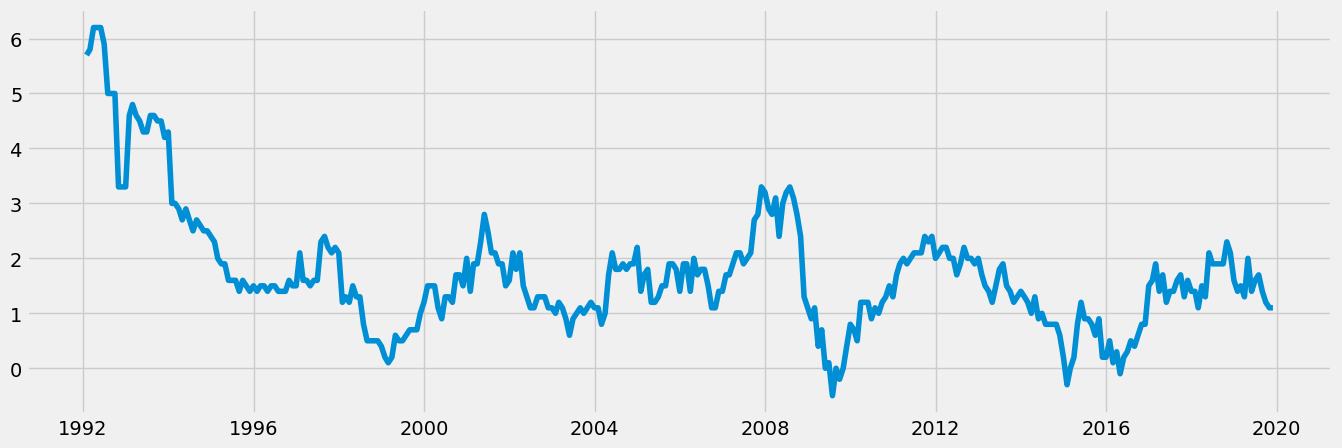

In [13]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [14]:
# Check for missing values

data_sub.isnull().sum()

Value    0
dtype: int64

In [16]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# It is very likely that the same inflation data happen to be more then one time.
# Therefore I will not drop the duplicates.

287

## 03. Time-series analysis: decomposition

In [17]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

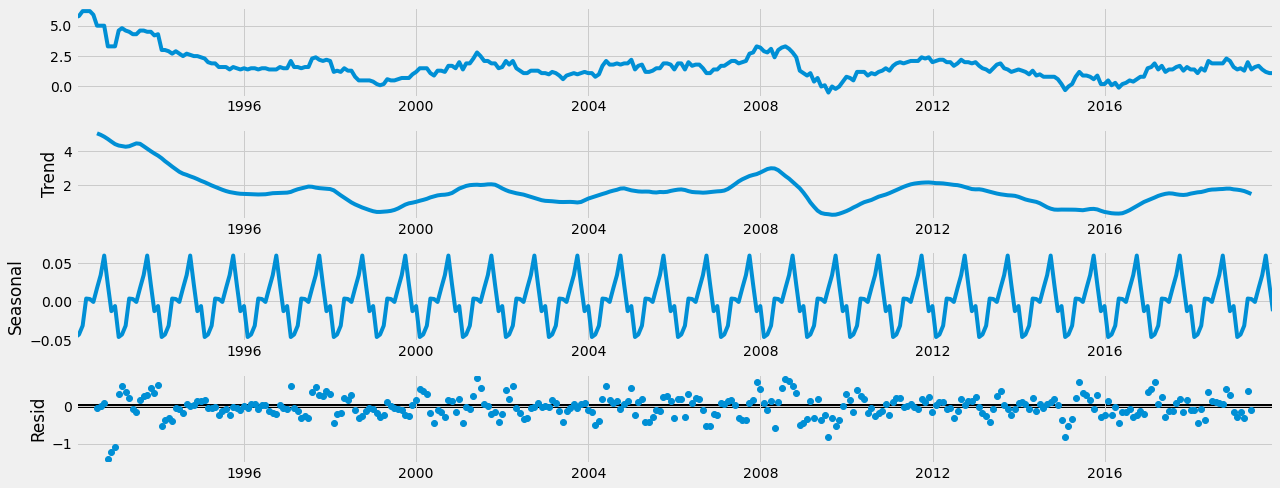

In [19]:
# Plot the separate components

decomposition.plot()
plt.show()

#### There is definitly seaonality in the data. If there is a trend, I am not sure. But there seems rather much noise.

## 04. Testing for stationarity

In [20]:
# Testing for stationarity with the dickey fuller test

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -3.750746
p-value                          0.003453
Number of Lags Used             12.000000
Number of Observations Used    322.000000
Critical Value (1%)             -3.450823
Critical Value (5%)             -2.870558
Critical Value (10%)            -2.571575
dtype: float64


#### But the test shows data is stationary. Maybe the data period for inflation is too short. Because it seems inflation stayed rather low since the 90is. But before inflation was much higher. And it seems that we are going into a period with higher inflation again.

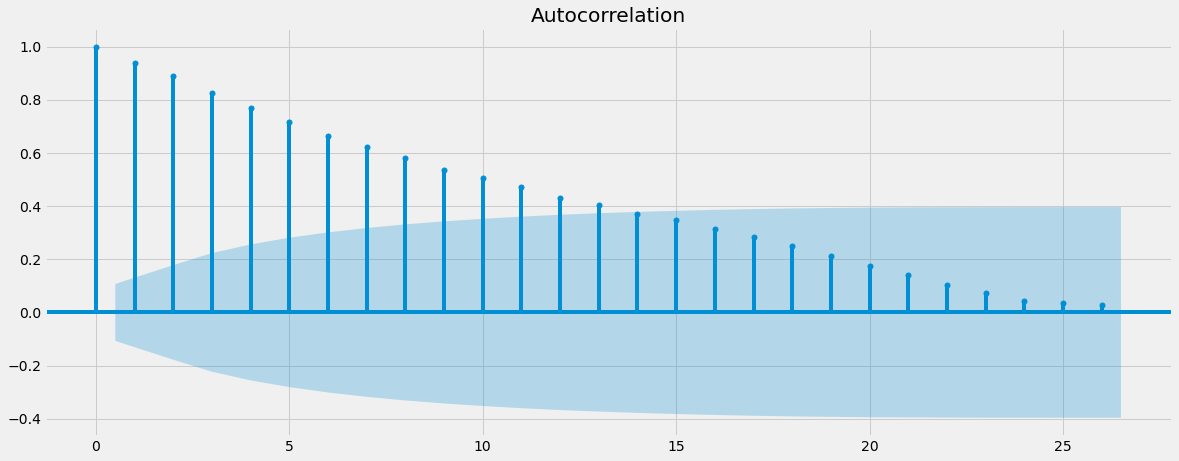

In [21]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

#### But autocorrelation seems to be present. And this paper said (https://www-users.york.ac.uk/~pb539/Research/isinflation.pdf), that there is no conclusive evidence if inflation should generally be treated stationary or non-stationary.

#### I will try to make it stationary, maybe we get an even more robust result from the dickey fuller test.

## 05. Stationarizing Inflation Data

In [22]:
# differentiong data
data_diff = data_sub - data_sub.shift(1)

In [23]:
# remove missing values
data_diff.dropna(inplace = True)

In [24]:
data_diff.head()

,Value
datetime,
1992-02-29,0.1
1992-03-31,0.4
1992-04-30,0.0
1992-05-31,0.0
1992-06-30,-0.3


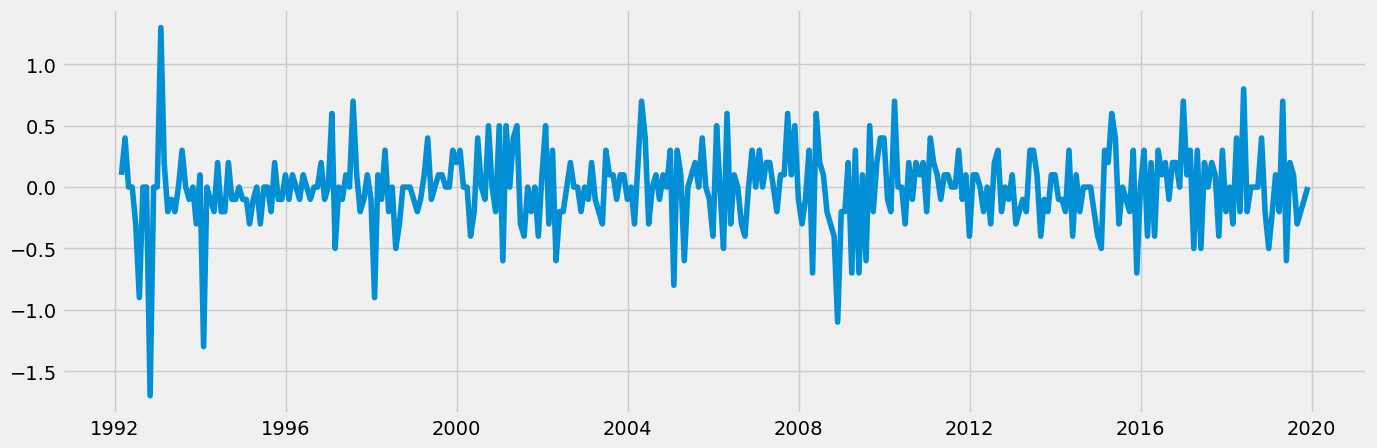

In [25]:
# Ploting differencing data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [31]:
# testing
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -6.290998e+00
p-value                        3.599598e-08
Number of Lags Used            1.100000e+01
Number of Observations Used    3.220000e+02
Critical Value (1%)           -3.450823e+00
Critical Value (5%)           -2.870558e+00
Critical Value (10%)          -2.571575e+00
dtype: float64


#### Here the p-value (0,0000) is even more significant then before.

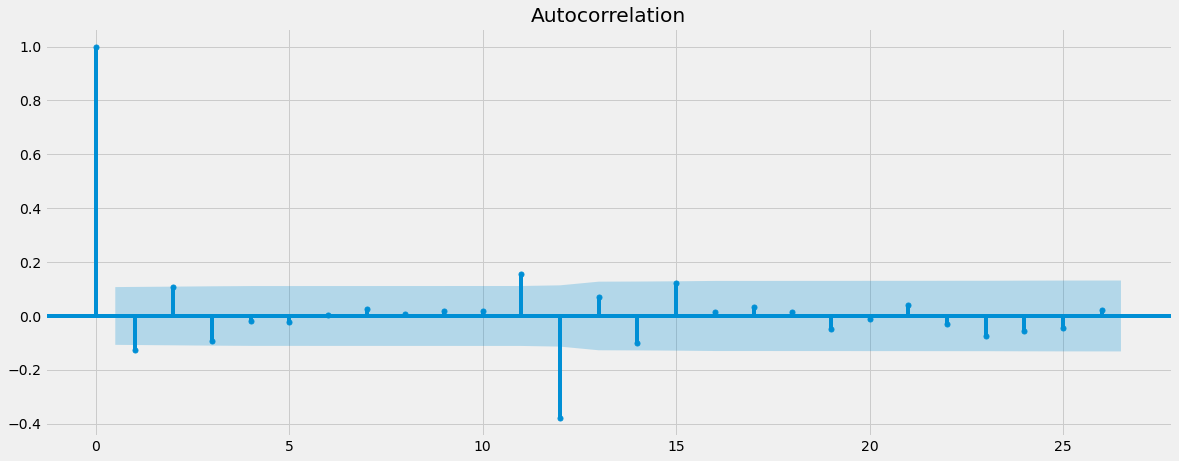

In [32]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff)
plt.show()

#### Now there is only little autocorrelation present.

## 06. Bonus Task: Forecast

## 06a. Defining parameters

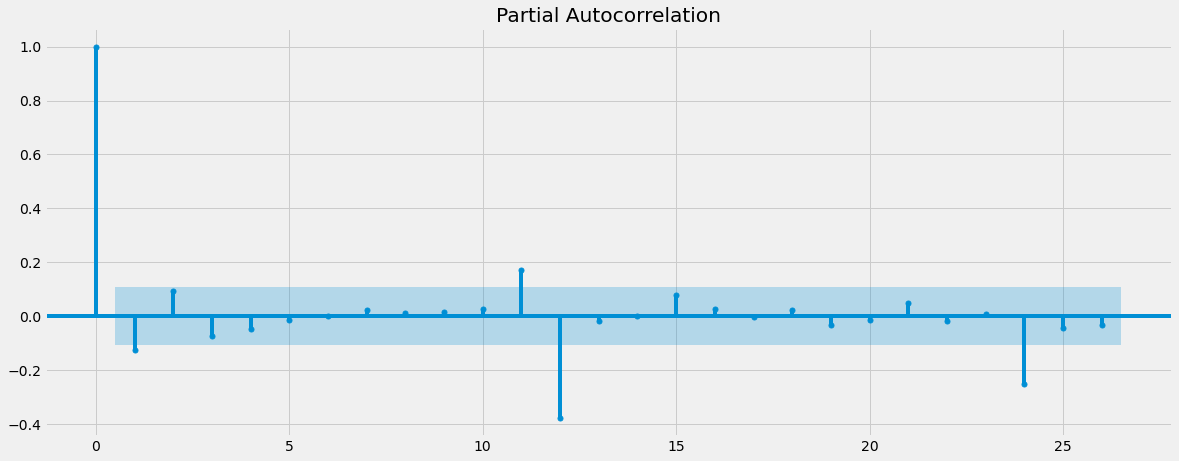

<Figure size 4500x4500 with 0 Axes>

In [33]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### I will choose p = 4 for the 4 lines that are siginifcantly outside the confidence intervall.

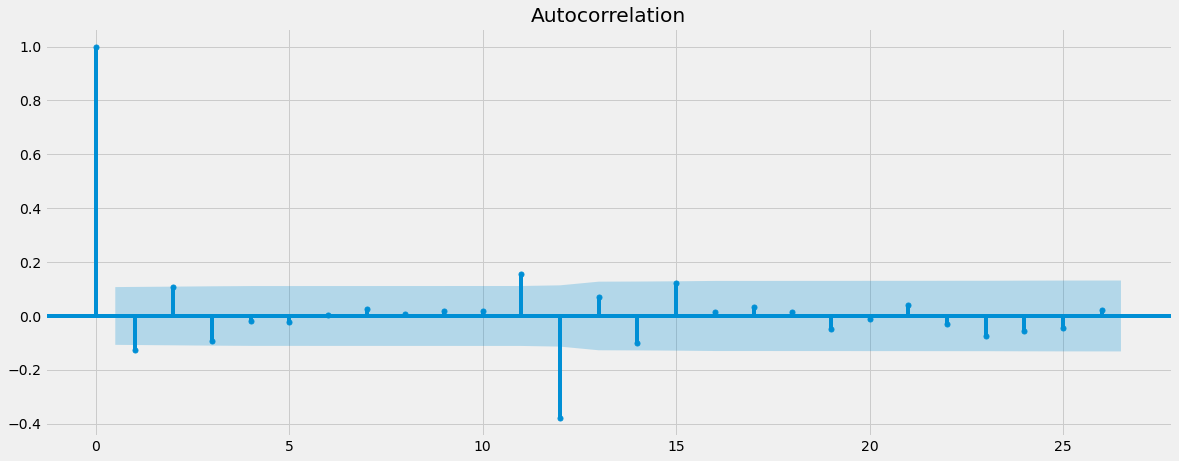

<Figure size 1500x500 with 0 Axes>

In [34]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

#### I will choose q = 3 for the 3 lines that are significantly outside the confidence interval.

## 06b. Splitting data of difference

In [35]:
data_diff.shape

(334, 1)

In [36]:
# Split the data 

train = data_diff['Value'][:234]
test = data_diff['Value'][233:]

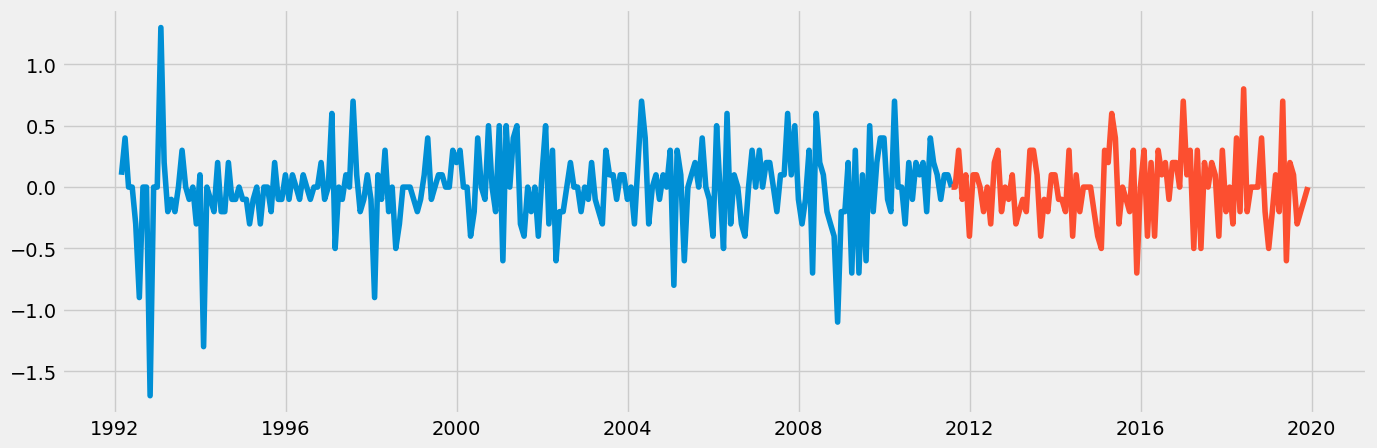

In [37]:
# Plot to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [43]:
test.shape

(101,)

## 06c. Running and Fitting the Model

In [41]:
# parameter p = 4 (AR), d = 1 (Difference), q = 3 (MA), 
from statsmodels.tsa.api import ARIMA # Import the model you need

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(4, 1, 3)   Log Likelihood                 -71.329
Method:                       css-mle   S.D. of innovations              0.323
Date:                Sat, 09 Jul 2022   AIC                            160.657
Time:                        19:22:17   BIC                            191.717
Sample:                    03-31-1992   HQIC                           173.182
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.418      0.156      -0.000       0.001
ar.L1.D.Value    -0.9020      0.067    -13.371      0.000      -1.034      -0.770
ar.L2.D.Value    -0.9782      0.089    -

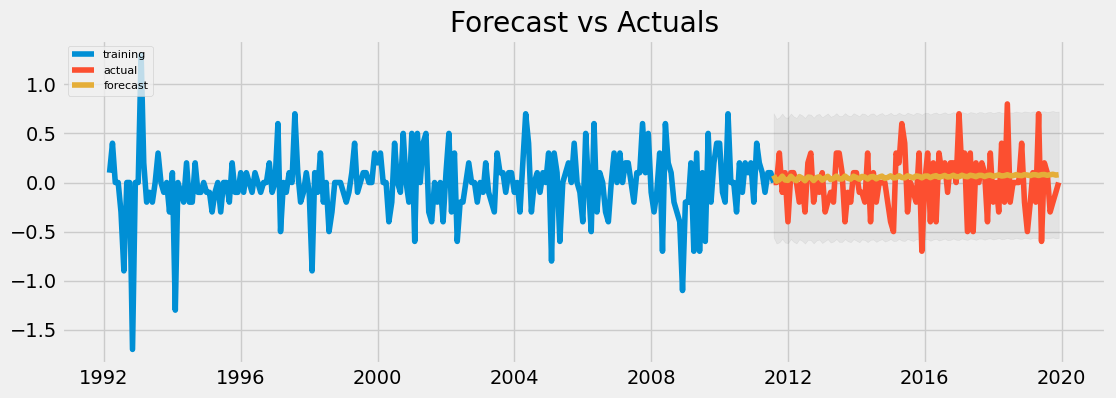

In [44]:
# running the model
model = ARIMA(train, order=(4, 1, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### 2 AR are not significant and the forcast shows not much volatility im comparisson to the actual

## 06d. Iterations

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -69.630
Method:                       css-mle   S.D. of innovations              0.322
Date:                Sat, 09 Jul 2022   AIC                            153.260
Time:                        19:23:47   BIC                            177.417
Sample:                    03-31-1992   HQIC                           163.001
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.378      0.168      -0.000       0.001
ar.L1.D.Value    -1.1606      0.048    -24.353      0.000      -1.254      -1.067
ar.L2.D.Value    -0.9096      0.045    -

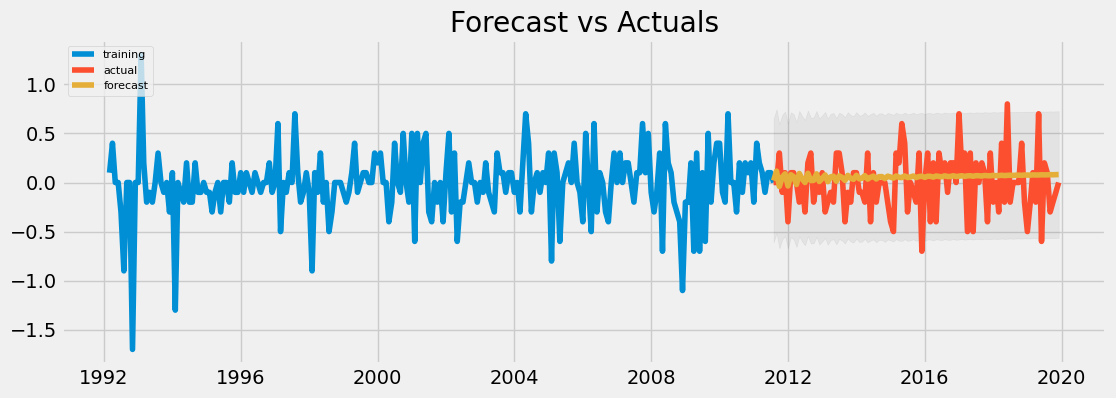

In [45]:
# running the model
model = ARIMA(train, order=(2, 1, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### Now all the variables are significant, but the forecast seems not good.

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 -68.994
Method:                       css-mle   S.D. of innovations              0.319
Date:                Sat, 09 Jul 2022   AIC                            153.988
Time:                        19:25:29   BIC                            181.596
Sample:                    03-31-1992   HQIC                           165.121
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.488      0.137      -0.000       0.001
ar.L1.D.Value    -1.2126      0.067    -18.039      0.000      -1.344      -1.081
ar.L2.D.Value    -0.9978      0.081    -

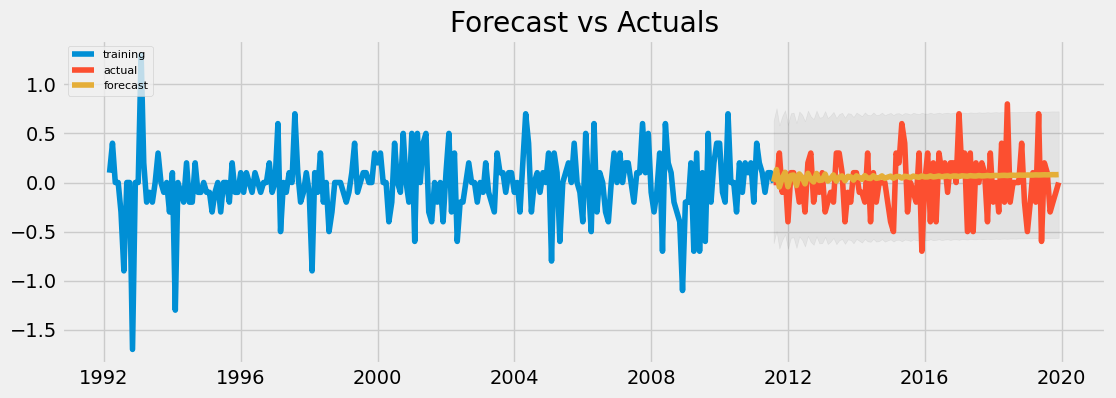

In [46]:
# running the model
model = ARIMA(train, order=(3, 1, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 -69.571
Method:                       css-mle   S.D. of innovations              0.322
Date:                Sat, 09 Jul 2022   AIC                            155.143
Time:                        19:26:21   BIC                            182.751
Sample:                    03-31-1992   HQIC                           166.275
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.484      0.138      -0.000       0.001
ar.L1.D.Value    -0.9444      0.110     -8.616      0.000      -1.159      -0.730
ar.L2.D.Value    -0.8249      0.129     

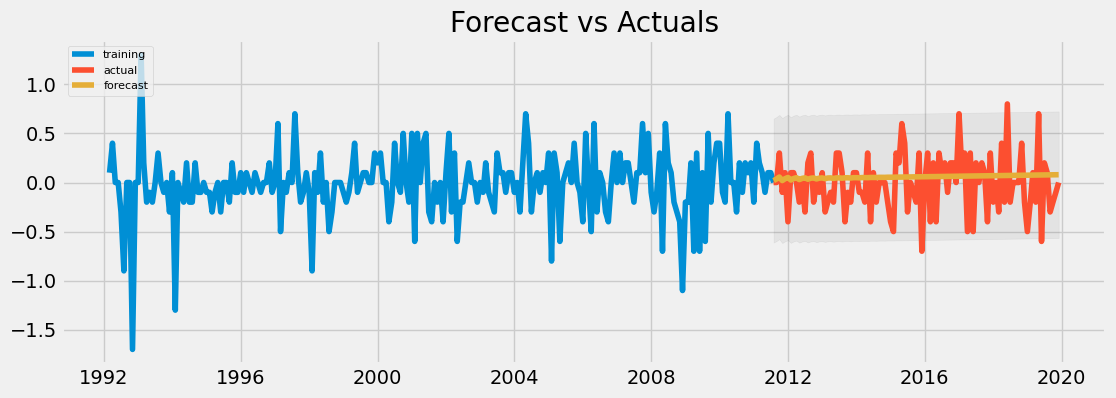

In [47]:
# running the model
model = ARIMA(train, order=(2, 1, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(3, 1, 4)   Log Likelihood                 -71.085
Method:                       css-mle   S.D. of innovations              0.319
Date:                Sat, 09 Jul 2022   AIC                            160.170
Time:                        19:26:43   BIC                            191.230
Sample:                    03-31-1992   HQIC                           172.695
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      2.526      0.012    8.36e-05       0.001
ar.L1.D.Value    -0.5101      0.044    -11.647      0.000      -0.596      -0.424
ar.L2.D.Value     0.3959      0.062     

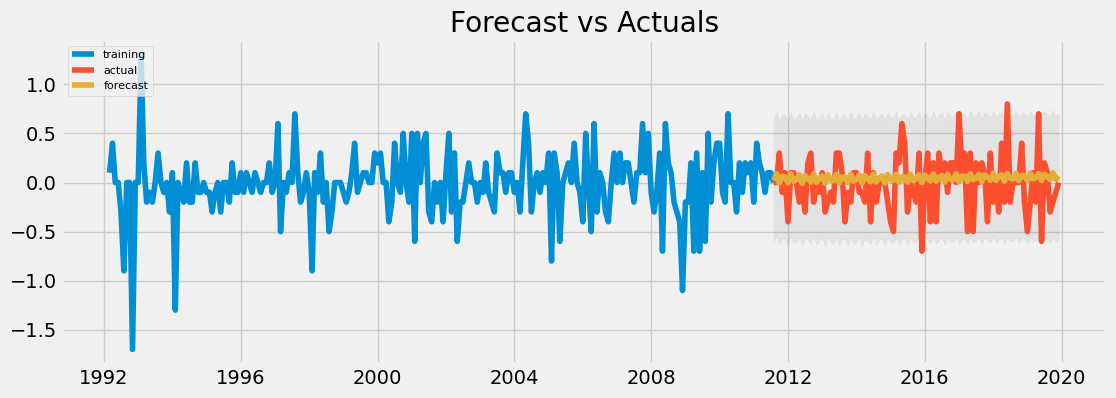

In [48]:
# running the model
model = ARIMA(train, order=(3, 1, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(4, 1, 4)   Log Likelihood                 -68.820
Method:                       css-mle   S.D. of innovations              0.318
Date:                Sat, 09 Jul 2022   AIC                            157.641
Time:                        19:27:02   BIC                            192.151
Sample:                    03-31-1992   HQIC                           171.557
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.635      0.102   -9.17e-05       0.001
ar.L1.D.Value    -0.5529      0.067     -8.251      0.000      -0.684      -0.422
ar.L2.D.Value    -0.5222      0.044    -

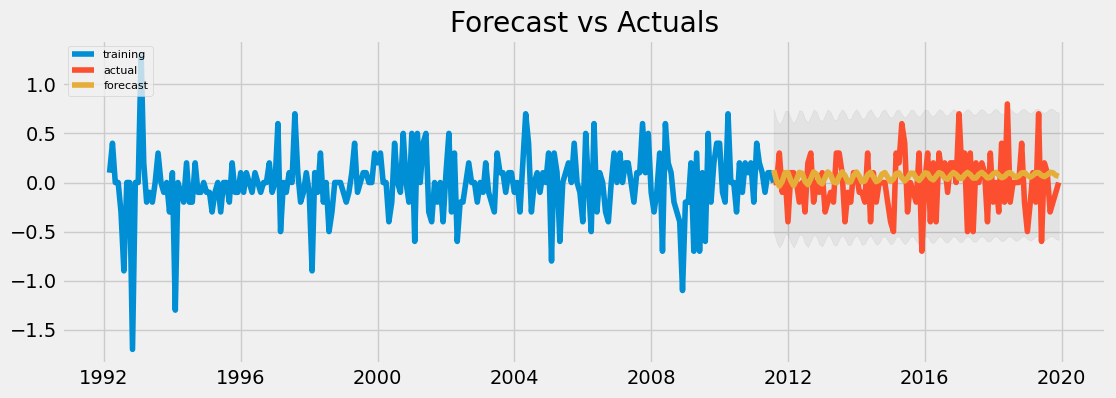

In [49]:
# running the model
model = ARIMA(train, order=(4, 1, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  233
Model:                 ARIMA(4, 1, 5)   Log Likelihood                 -64.706
Method:                       css-mle   S.D. of innovations              0.313
Date:                Sat, 09 Jul 2022   AIC                            151.412
Time:                        19:27:54   BIC                            189.373
Sample:                    03-31-1992   HQIC                           166.720
                         - 07-31-2011                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.496      0.135      -0.000       0.001
ar.L1.D.Value    -1.3475      0.063    -21.259      0.000      -1.472      -1.223
ar.L2.D.Value    -0.8661      0.055    -

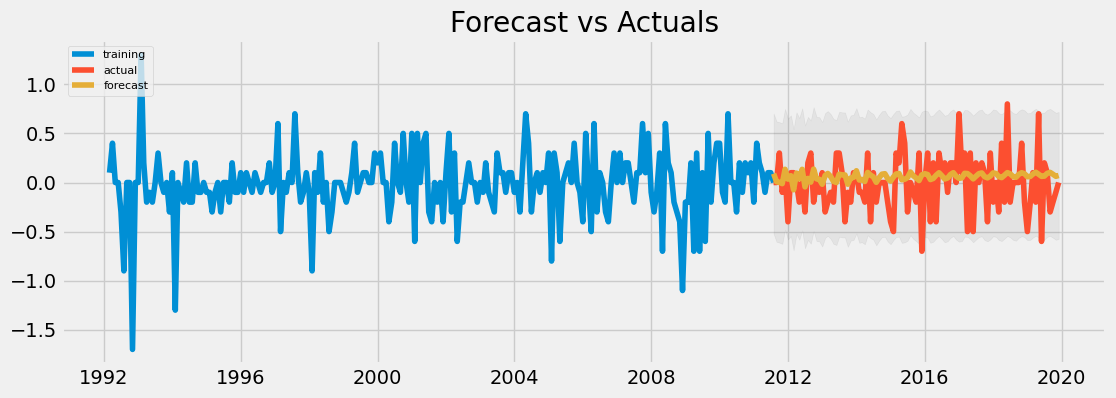

In [51]:
# running the model
model = ARIMA(train, order=(4, 1, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(101, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### This seems to be the best model for the difference data. For all variables the p-value is significant and the forecast has a more variation then my first iterations. And only some of the actual data is not in the confidence interval

#### But lets try to forecast without difference

## 06e. Defining parameters

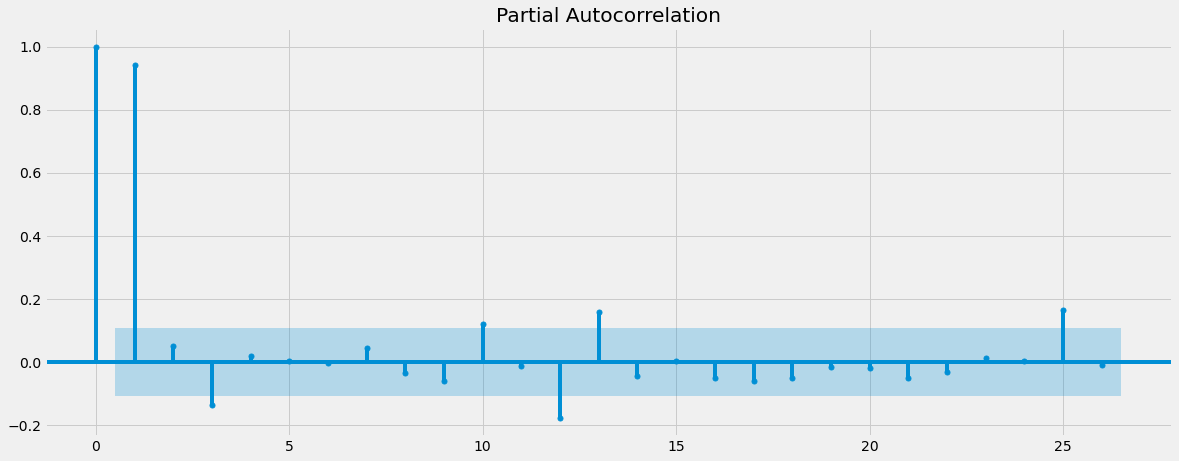

<Figure size 4500x4500 with 0 Axes>

In [59]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(data_sub)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### The data seems to suggest 7, but I will start conservative with p = 3

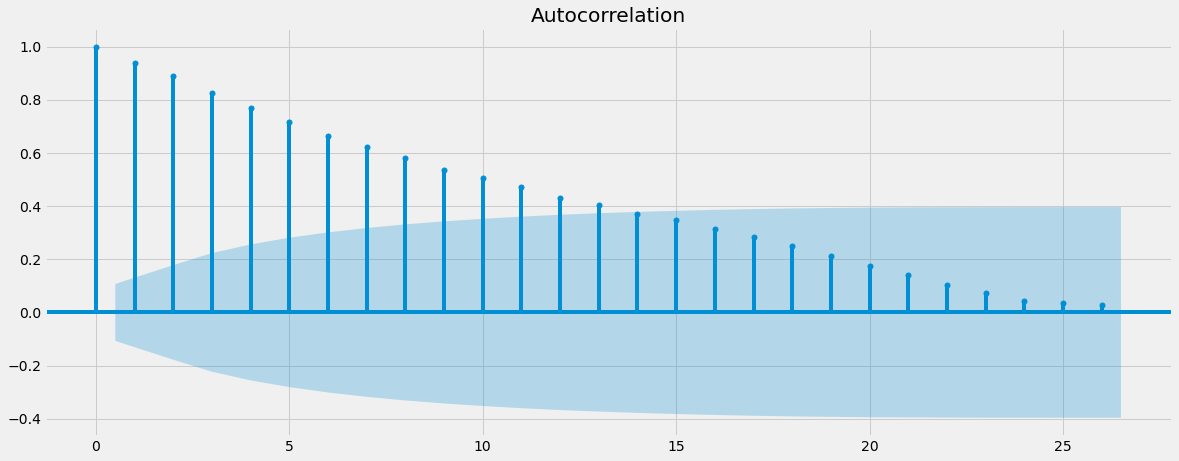

<Figure size 1500x500 with 0 Axes>

In [60]:
# Plot autocorrelations to determine parameter q

plot_acf(data_sub)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

#### As there seems to be high autocorrelation, I will start with q = 3

## 06f. Splitting data without difference

In [62]:
data_sub.shape

(335, 1)

In [63]:
# Split the data 

train = data_sub['Value'][:234]
test = data_sub['Value'][233:]

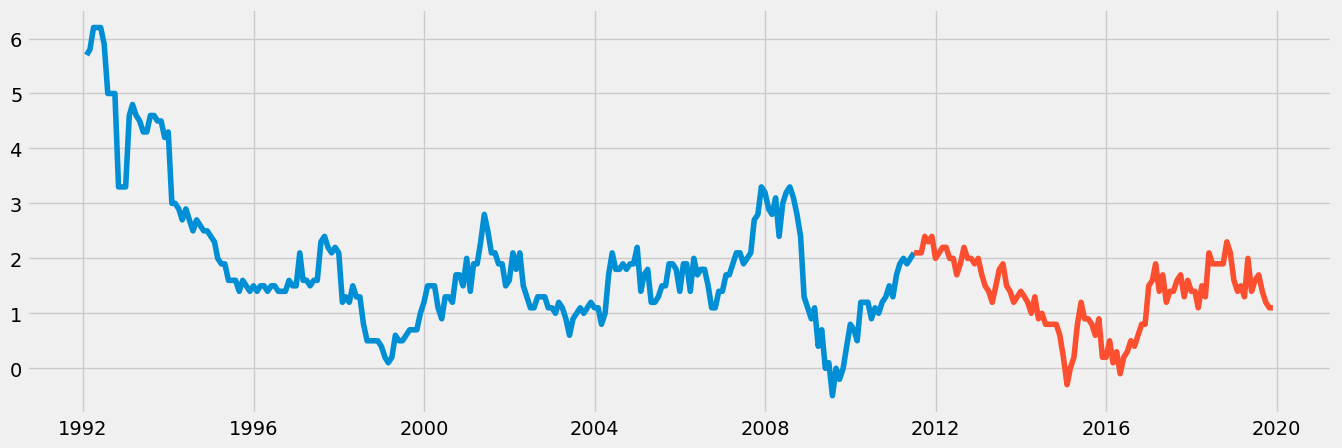

In [64]:
# Plot to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [65]:
test.shape

(102,)

## 06g. Running and Fitting the Model

In [61]:
# parameter p = 3 (AR), d = 0 (Difference), q = 3 (MA), 
from statsmodels.tsa.api import ARIMA

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(3, 3)   Log Likelihood                 -71.813
Method:                       css-mle   S.D. of innovations              0.327
Date:                Sat, 09 Jul 2022   AIC                            159.626
Time:                        19:41:41   BIC                            187.268
Sample:                    01-31-1992   HQIC                           170.771
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3102      0.753      3.067      0.002       0.834       3.786
ar.L1.Value     1.3000      0.614      2.117      0.034       0.097       2.503
ar.L2.Value     0.1676      0.894      0.187    

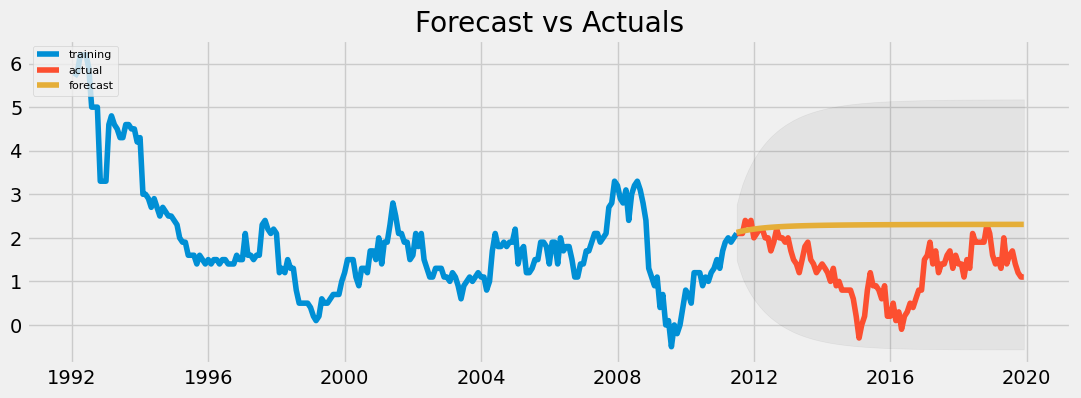

In [66]:
# running the model
model = ARIMA(train, order=(3, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### This seems a bad fit. No p-value is significant, the forcast line is completley different then the actual line. But the actual line is completly inside the confidence interval.

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(2, 3)   Log Likelihood                 -71.535
Method:                       css-mle   S.D. of innovations              0.326
Date:                Sat, 09 Jul 2022   AIC                            157.071
Time:                        19:45:32   BIC                            181.258
Sample:                    01-31-1992   HQIC                           166.823
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1416      0.467      4.584      0.000       1.226       3.057
ar.L1.Value     1.9721      0.017    118.552      0.000       1.940       2.005
ar.L2.Value    -0.9728      0.017    -58.746    

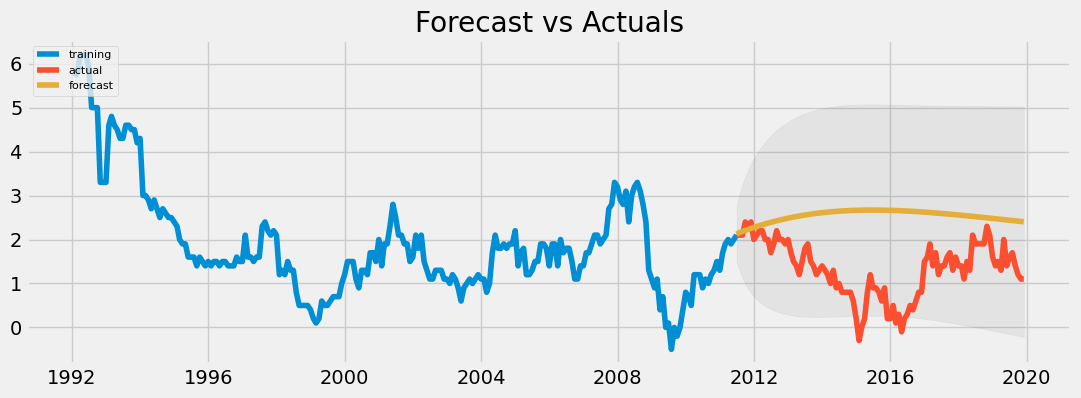

In [67]:
# running the model
model = ARIMA(train, order=(2, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(1, 3)   Log Likelihood                 -71.993
Method:                       css-mle   S.D. of innovations              0.327
Date:                Sat, 09 Jul 2022   AIC                            155.987
Time:                        19:46:10   BIC                            176.719
Sample:                    01-31-1992   HQIC                           164.346
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.4128      0.837      2.881      0.004       0.772       4.054
ar.L1.Value     0.9765      0.018     55.674      0.000       0.942       1.011
ma.L1.Value    -0.0556      0.068     -0.817    

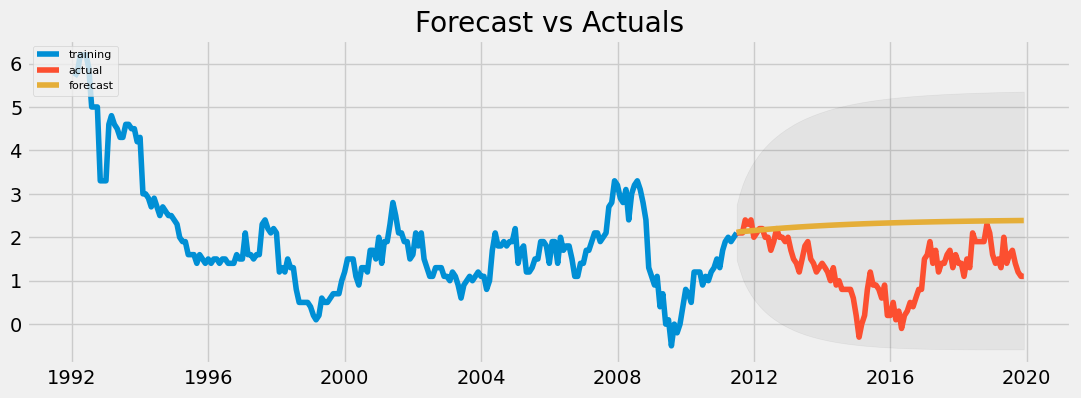

In [70]:
# running the model
model = ARIMA(train, order=(1, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 3)   Log Likelihood                 -65.240
Method:                       css-mle   S.D. of innovations              0.314
Date:                Sat, 09 Jul 2022   AIC                            148.480
Time:                        19:46:31   BIC                            179.578
Sample:                    01-31-1992   HQIC                           161.018
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3978      0.817      2.933      0.003       0.796       4.000
ar.L1.Value     1.6011      0.055     29.044      0.000       1.493       1.709
ar.L2.Value     0.0443      0.099      0.449    

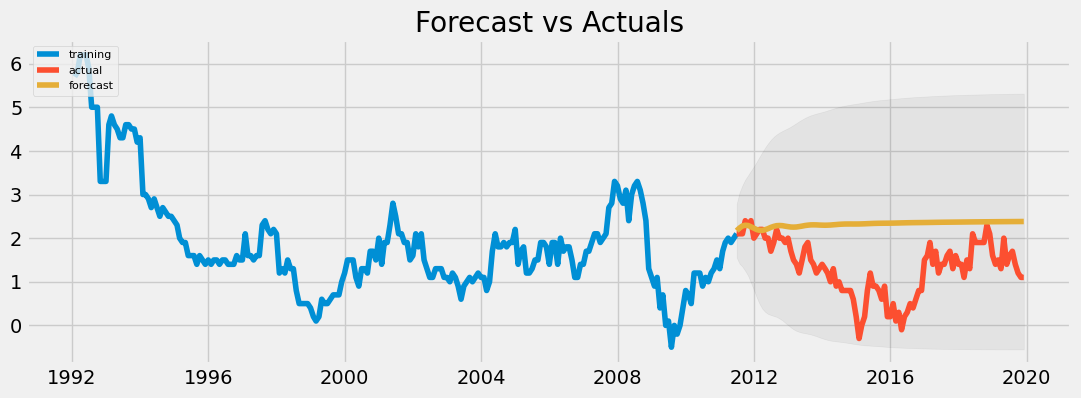

In [71]:
# running the model
model = ARIMA(train, order=(4, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(5, 3)   Log Likelihood                 -65.996
Method:                       css-mle   S.D. of innovations              0.316
Date:                Sat, 09 Jul 2022   AIC                            151.993
Time:                        19:46:54   BIC                            186.546
Sample:                    01-31-1992   HQIC                           165.925
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.4002      0.817      2.937      0.003       0.798       4.002
ar.L1.Value     0.3835      0.321      1.193      0.233      -0.246       1.013
ar.L2.Value    -0.2403      0.297     -0.809    

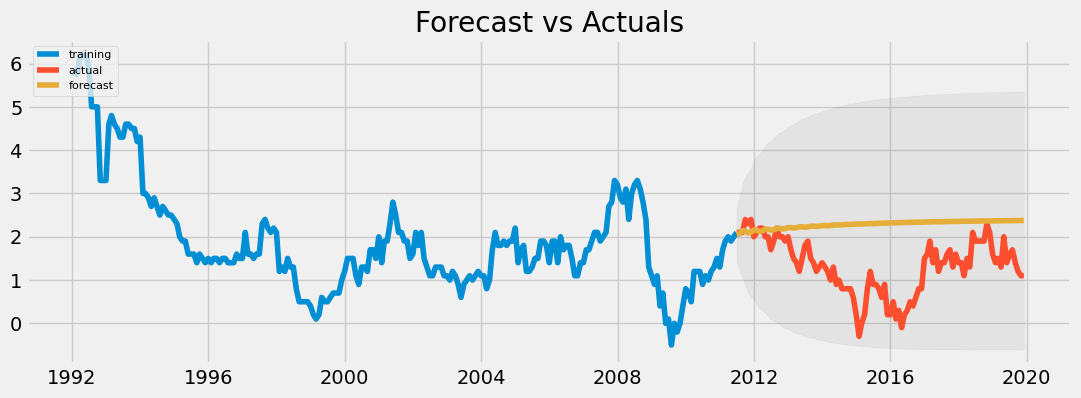

In [72]:
# running the model
model = ARIMA(train, order=(5, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(6, 3)   Log Likelihood                 -68.887
Method:                       css-mle   S.D. of innovations              0.320
Date:                Sat, 09 Jul 2022   AIC                            159.773
Time:                        19:47:12   BIC                            197.782
Sample:                    01-31-1992   HQIC                           175.098
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3590      0.772      3.055      0.002       0.845       3.873
ar.L1.Value    -0.2551      1.643     -0.155      0.877      -3.476       2.966
ar.L2.Value     0.0220      0.074      0.297    

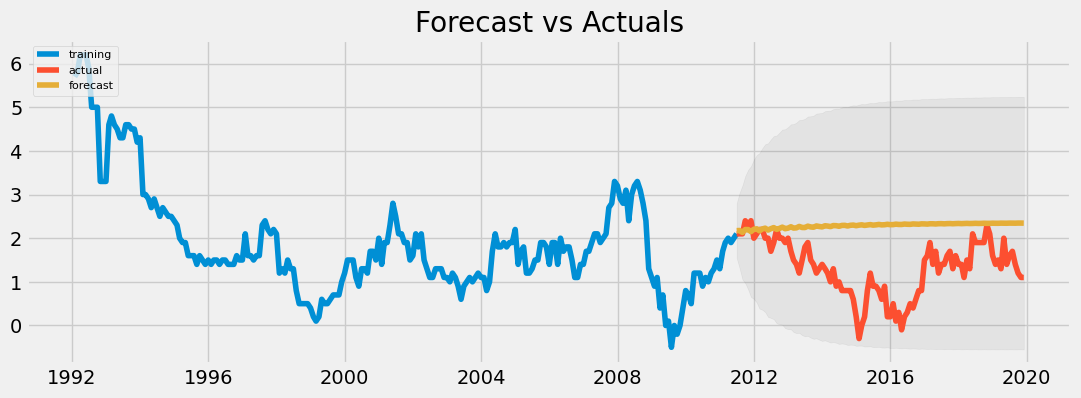

In [73]:
# running the model
model = ARIMA(train, order=(6, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 4)   Log Likelihood                 -65.230
Method:                       css-mle   S.D. of innovations              0.314
Date:                Sat, 09 Jul 2022   AIC                            150.460
Time:                        19:47:35   BIC                            185.014
Sample:                    01-31-1992   HQIC                           164.392
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.4053      0.829      2.903      0.004       0.781       4.029
ar.L1.Value     1.6062      0.066     24.234      0.000       1.476       1.736
ar.L2.Value     0.0375      0.110      0.342    

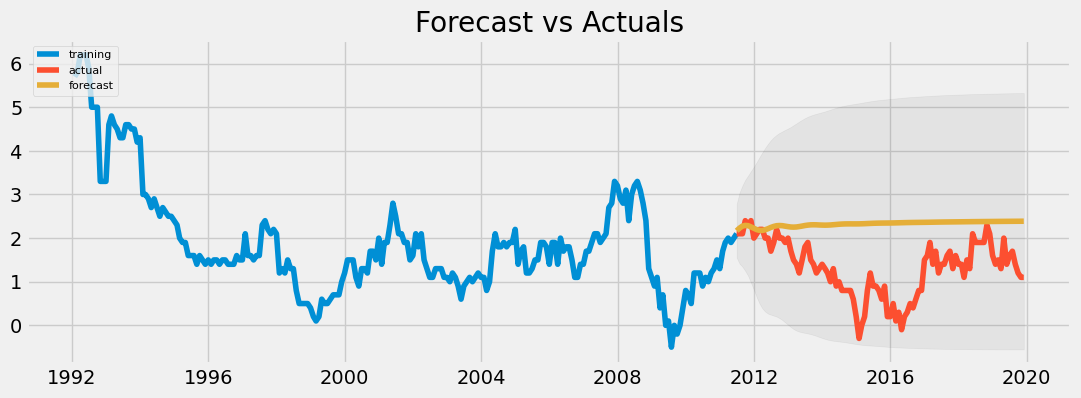

In [74]:
# running the model
model = ARIMA(train, order=(4, 0, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 5)   Log Likelihood                 -61.550
Method:                       css-mle   S.D. of innovations              0.309
Date:                Sat, 09 Jul 2022   AIC                            145.099
Time:                        19:48:01   BIC                            183.108
Sample:                    01-31-1992   HQIC                           160.424
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3199      0.716      3.239      0.001       0.916       3.723
ar.L1.Value     1.5650      0.070     22.392      0.000       1.428       1.702
ar.L2.Value    -0.0036      0.121     -0.029    

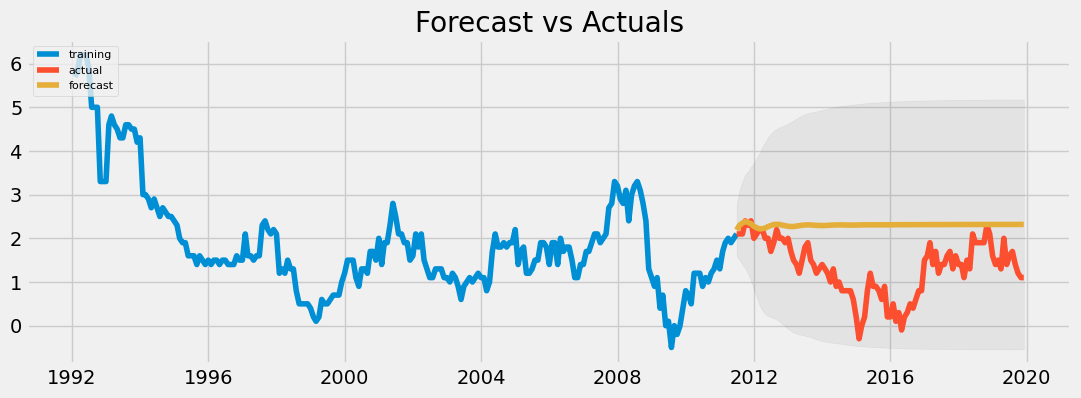

In [75]:
# running the model
model = ARIMA(train, order=(4, 0, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 6)   Log Likelihood                 -61.486
Method:                       css-mle   S.D. of innovations              0.309
Date:                Sat, 09 Jul 2022   AIC                            146.973
Time:                        19:48:16   BIC                            188.437
Sample:                    01-31-1992   HQIC                           163.691
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3051      0.699      3.297      0.001       0.935       3.675
ar.L1.Value     1.5497      0.082     18.790      0.000       1.388       1.711
ar.L2.Value     0.0117      0.128      0.092    

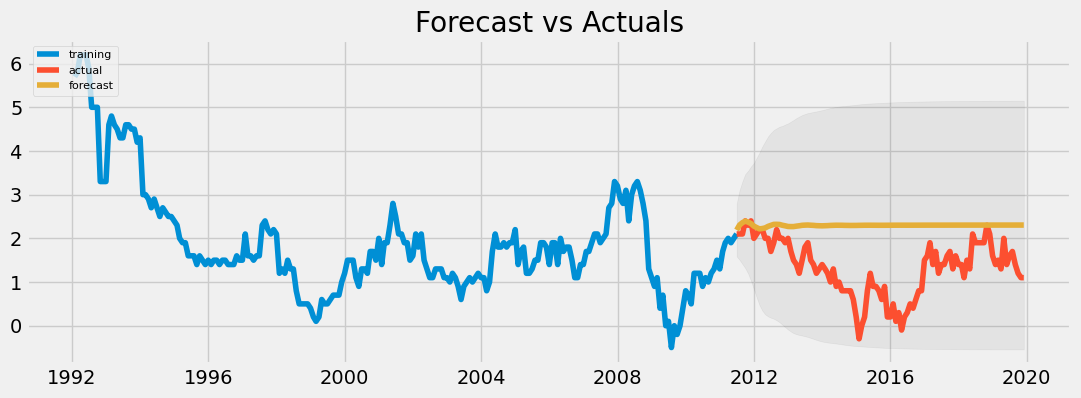

In [76]:
# running the model
model = ARIMA(train, order=(4, 0, 6))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 7)   Log Likelihood                 -59.245
Method:                       css-mle   S.D. of innovations              0.305
Date:                Sat, 09 Jul 2022   AIC                            144.489
Time:                        19:48:40   BIC                            189.408
Sample:                    01-31-1992   HQIC                           162.601
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2180      0.597      3.716      0.000       1.048       3.388
ar.L1.Value     1.5566      0.088     17.686      0.000       1.384       1.729
ar.L2.Value    -0.1382      0.197     -0.702    

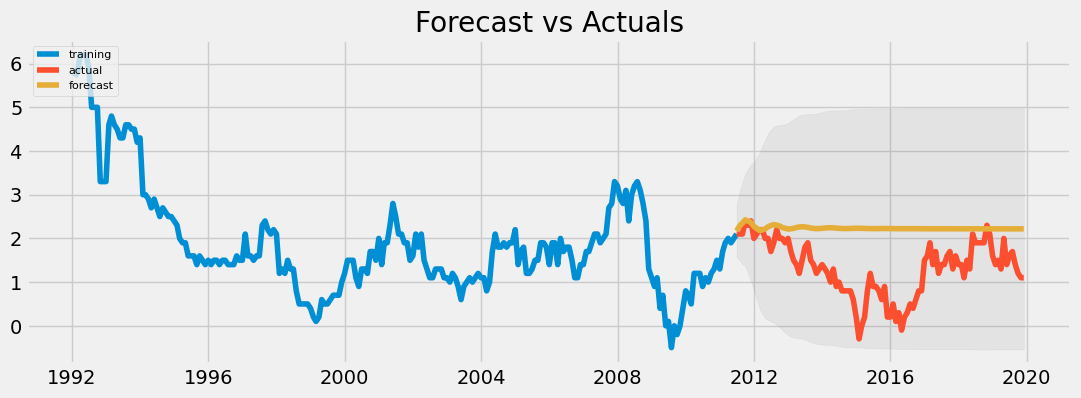

In [77]:
# running the model
model = ARIMA(train, order=(4, 0, 7))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### More q for MA does not help.

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                  234
Model:                     ARMA(4, 3)   Log Likelihood                 -65.240
Method:                       css-mle   S.D. of innovations              0.314
Date:                Sat, 09 Jul 2022   AIC                            148.480
Time:                        19:50:11   BIC                            179.578
Sample:                    01-31-1992   HQIC                           161.018
                         - 06-30-2011                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3978      0.817      2.933      0.003       0.796       4.000
ar.L1.Value     1.6011      0.055     29.044      0.000       1.493       1.709
ar.L2.Value     0.0443      0.099      0.449    

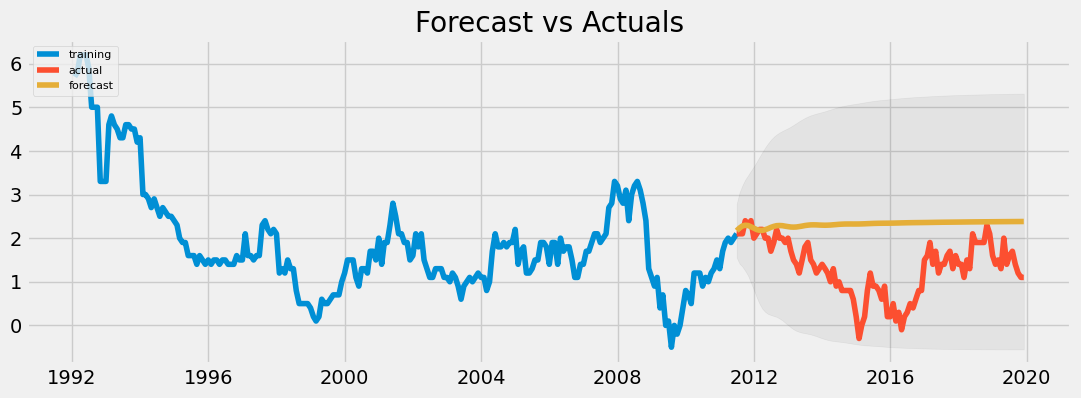

In [78]:
# running the model
model = ARIMA(train, order=(4, 0, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(102, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### This seems to be the best fit for the ARMA model. But I think the forecast is even more different the with the ARIMA model.

## 7. Lets try a second difference

In [79]:
# differentiong data
data_diff_2 = data_diff - data_diff.shift(1)

In [80]:
# remove missing values
data_diff_2.dropna(inplace = True)

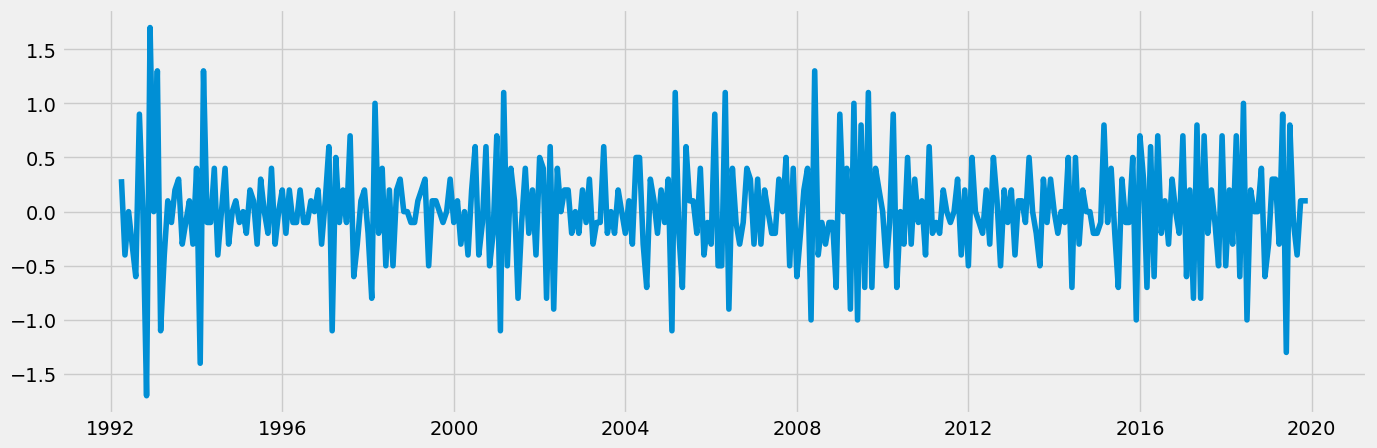

In [81]:
# Ploting differencing data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [82]:
data_diff_2.head()

,Value
datetime,
1992-03-31,0.3
1992-04-30,-0.4
1992-05-31,0.0
1992-06-30,-0.3
1992-07-31,-0.6


In [83]:
# testing
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -8.175579e+00
p-value                        8.394836e-13
Number of Lags Used            1.400000e+01
Number of Observations Used    3.180000e+02
Critical Value (1%)           -3.451082e+00
Critical Value (5%)           -2.870672e+00
Critical Value (10%)          -2.571636e+00
dtype: float64


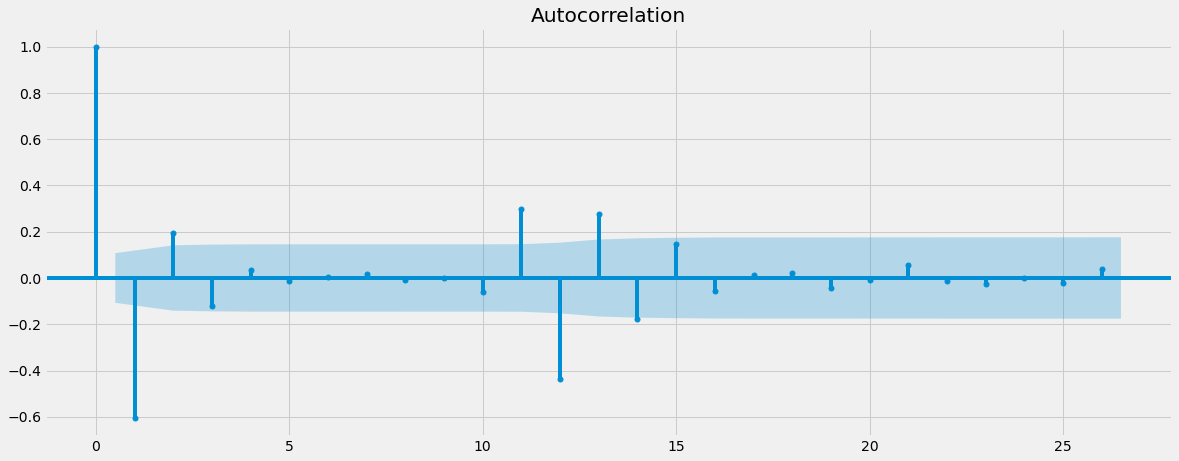

In [84]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff_2)
plt.show()

#### No stationarity. For a conservative approach q = 3

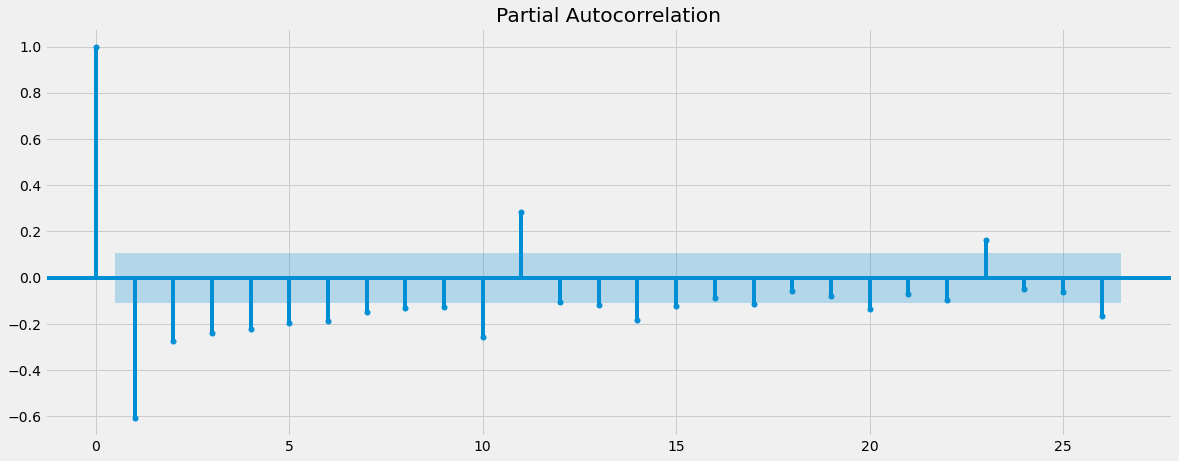

<Figure size 4500x4500 with 0 Axes>

In [85]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(data_diff_2)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### It seems that partial autocorrelation is high with the second diff. p = 3

In [86]:
data_diff_2.shape

(333, 1)

In [87]:
# Split the data 

train = data_diff_2['Value'][:234]
test = data_diff_2['Value'][233:]

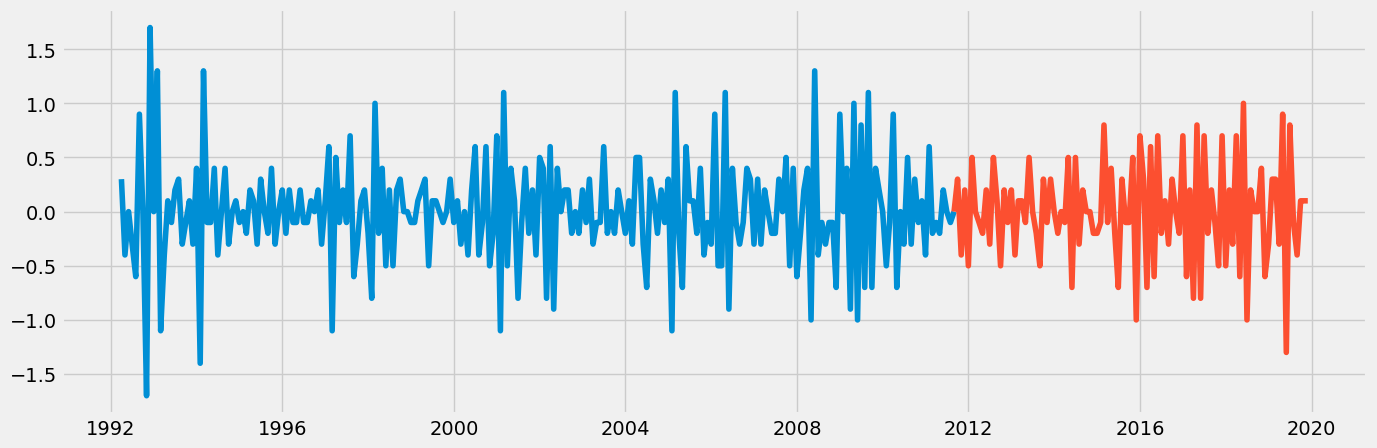

In [88]:
# Plot to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [89]:
test.shape

(100,)

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(3, 2, 3)   Log Likelihood                -114.056
Method:                       css-mle   S.D. of innovations              0.380
Date:                Sat, 09 Jul 2022   AIC                            244.112
Time:                        19:58:15   BIC                            271.685
Sample:                    05-31-1992   HQIC                           255.232
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.501e-06   2.36e-05     -0.106      0.915   -4.87e-05    4.37e-05
ar.L1.D2.Value    -1.7072      0.064    -26.829      0.000      -1.832      -1.582
ar.L2.D2.Value    -0.9858      0.112

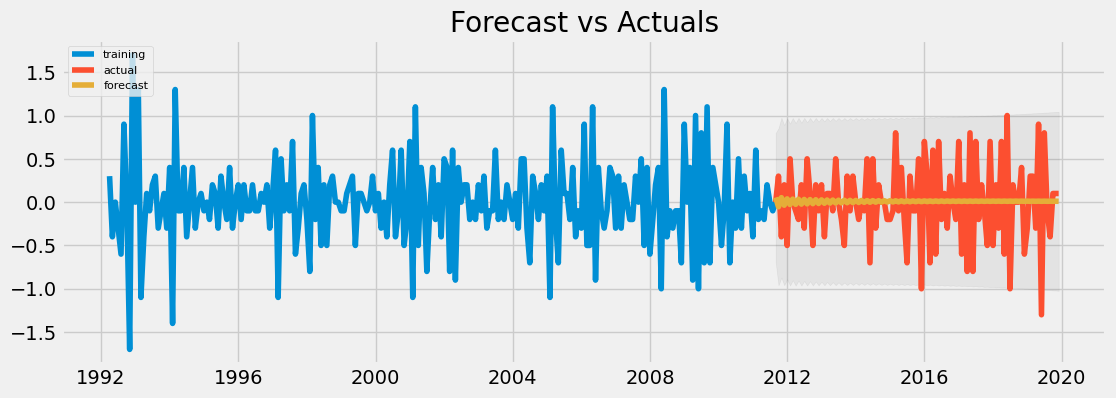

In [90]:
# running the model
model = ARIMA(train, order=(3, 2, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### The variation is again very small for the forecast in comparison to actual. p-values are significant

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(3, 2, 4)   Log Likelihood                -118.280
Method:                       css-mle   S.D. of innovations              0.386
Date:                Sat, 09 Jul 2022   AIC                            254.560
Time:                        19:59:38   BIC                            285.580
Sample:                    05-31-1992   HQIC                           267.070
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.167e-06   6.01e-05     -0.086      0.932      -0.000       0.000
ar.L1.D2.Value    -2.2590      0.052    -43.171      0.000      -2.362      -2.156
ar.L2.D2.Value    -1.9486      0.092

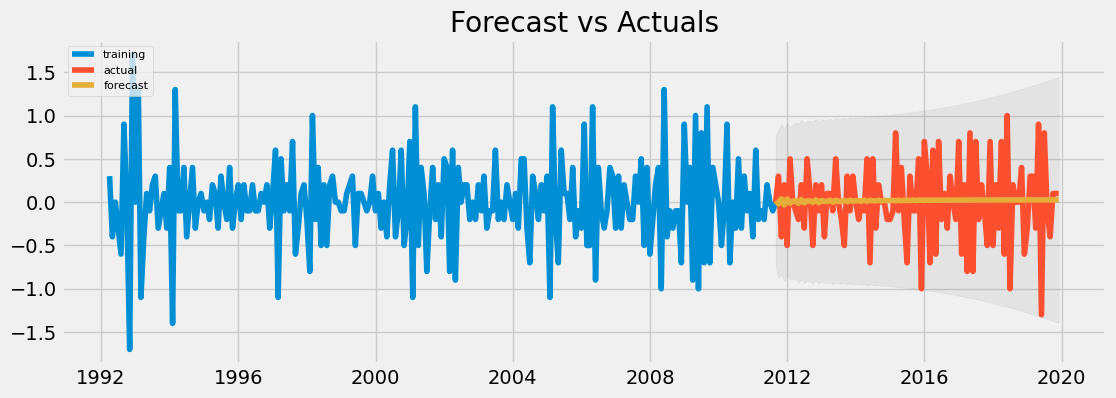

In [92]:
# running the model
model = ARIMA(train, order=(3, 2, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### For this model p-values are significant and the actual line is completly in the confidence intervall

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -112.220
Method:                       css-mle   S.D. of innovations              0.378
Date:                Sat, 09 Jul 2022   AIC                            244.440
Time:                        20:00:43   BIC                            278.908
Sample:                    05-31-1992   HQIC                           258.341
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.519e-06   4.17e-05     -0.108      0.914   -8.63e-05    7.72e-05
ar.L1.D2.Value    -1.7455      0.063    -27.683      0.000      -1.869      -1.622
ar.L2.D2.Value    -1.9988      0.110

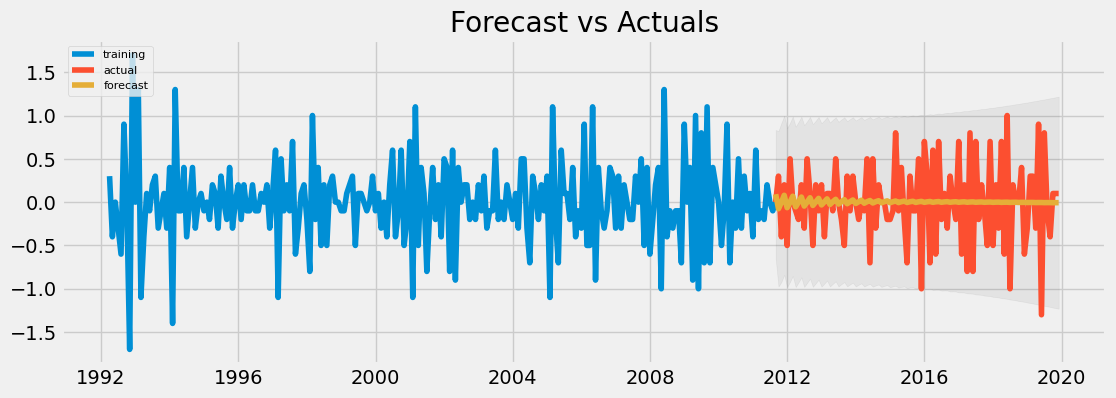

In [93]:
# running the model
model = ARIMA(train, order=(4, 2, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(4, 2, 5)   Log Likelihood                -118.926
Method:                       css-mle   S.D. of innovations              0.389
Date:                Sat, 09 Jul 2022   AIC                            259.851
Time:                        20:01:02   BIC                            297.765
Sample:                    05-31-1992   HQIC                           275.142
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.291e-06   9.88e-05     -0.064      0.949      -0.000       0.000
ar.L1.D2.Value    -2.5162      0.062    -40.326      0.000      -2.639      -2.394
ar.L2.D2.Value    -3.0536      0.122

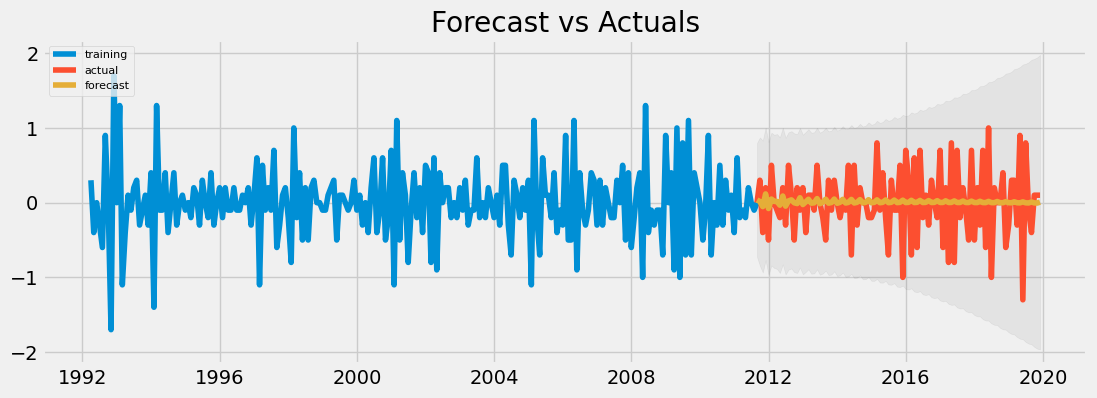

In [94]:
# running the model
model = ARIMA(train, order=(4, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(5, 2, 4)   Log Likelihood                -104.629
Method:                       css-mle   S.D. of innovations              0.361
Date:                Sat, 09 Jul 2022   AIC                            231.259
Time:                        20:01:26   BIC                            269.173
Sample:                    05-31-1992   HQIC                           246.549
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.589e-06   4.23e-05     -0.061      0.951   -8.55e-05    8.03e-05
ar.L1.D2.Value    -0.8530      0.064    -13.300      0.000      -0.979      -0.727
ar.L2.D2.Value    -1.4549      0.080

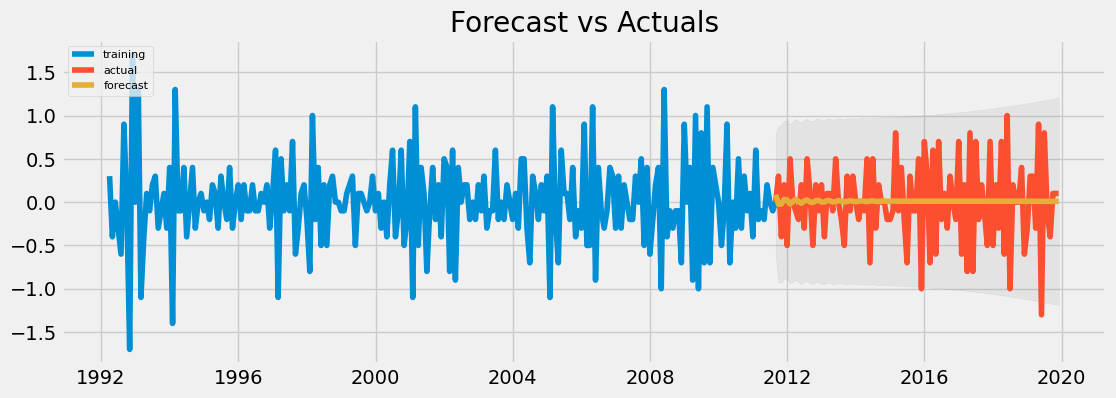

In [95]:
# running the model
model = ARIMA(train, order=(5, 2, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -119.214
Method:                       css-mle   S.D. of innovations              0.383
Date:                Sat, 09 Jul 2022   AIC                            262.428
Time:                        20:01:42   BIC                            303.788
Sample:                    05-31-1992   HQIC                           279.108
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.456e-07   5.63e-06     -0.168      0.867    -1.2e-05    1.01e-05
ar.L1.D2.Value    -1.1390      0.125     -9.084      0.000      -1.385      -0.893
ar.L2.D2.Value    -1.2314      0.081

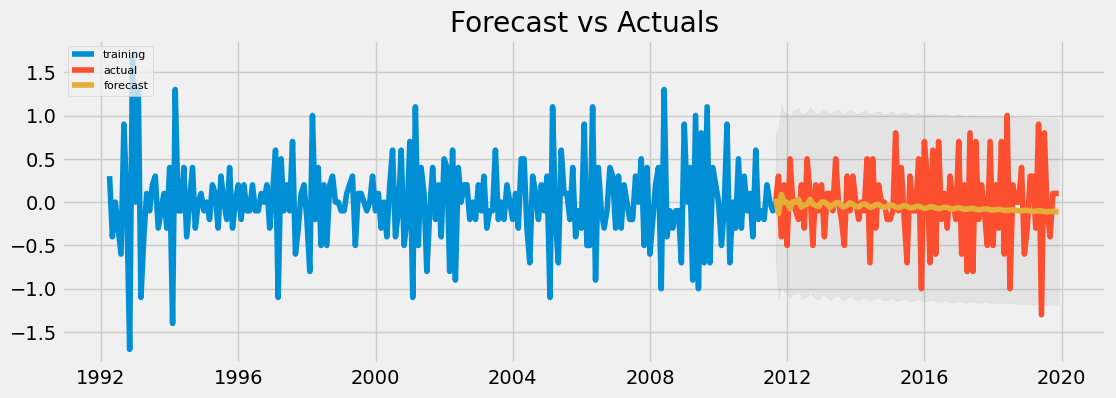

In [96]:
# running the model
model = ARIMA(train, order=(5, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Because of the high partial autocorrelation lets try to make p as high as possible.

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(6, 2, 5)   Log Likelihood                -102.022
Method:                       css-mle   S.D. of innovations              0.361
Date:                Sat, 09 Jul 2022   AIC                            230.045
Time:                        20:02:05   BIC                            274.852
Sample:                    05-31-1992   HQIC                           248.115
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.584e-06   1.28e-05     -0.124      0.901   -2.66e-05    2.35e-05
ar.L1.D2.Value    -2.7362        nan        nan        nan         nan         nan
ar.L2.D2.Value    -3.8401      0.227

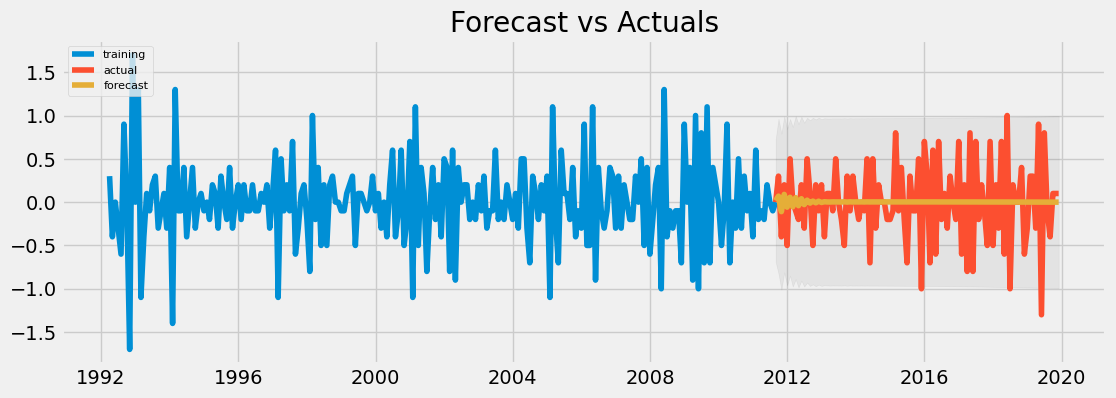

In [97]:
# running the model
model = ARIMA(train, order=(6, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(7, 2, 5)   Log Likelihood                -103.823
Method:                       css-mle   S.D. of innovations              0.365
Date:                Sat, 09 Jul 2022   AIC                            235.645
Time:                        20:02:45   BIC                            283.900
Sample:                    05-31-1992   HQIC                           255.106
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.152e-06   1.44e-05     -0.150      0.881   -3.03e-05     2.6e-05
ar.L1.D2.Value    -2.6608        nan        nan        nan         nan         nan
ar.L2.D2.Value    -3.7239        nan

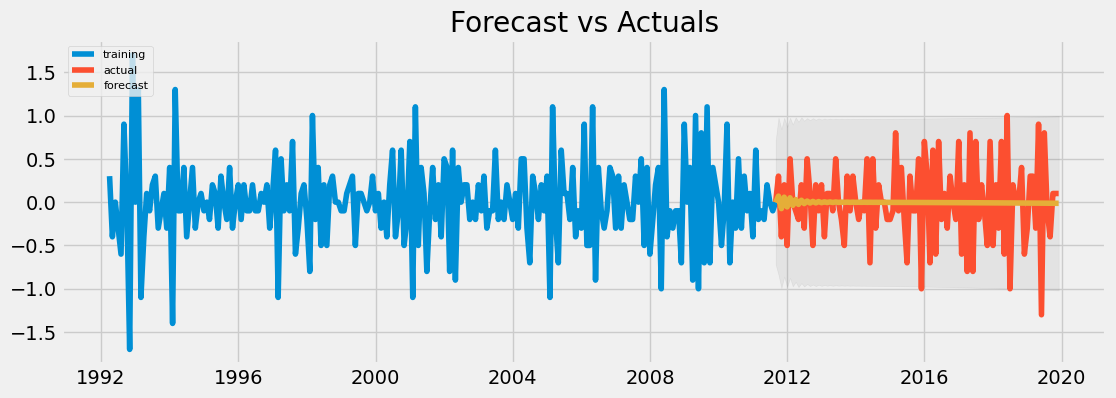

In [99]:
# running the model
model = ARIMA(train, order=(7, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(8, 2, 5)   Log Likelihood                 -98.456
Method:                       css-mle   S.D. of innovations              0.358
Date:                Sat, 09 Jul 2022   AIC                            226.912
Time:                        20:03:08   BIC                            278.613
Sample:                    05-31-1992   HQIC                           247.762
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.536e-05   7.03e-05     -0.218      0.827      -0.000       0.000
ar.L1.D2.Value    -2.9047      0.113    -25.809      0.000      -3.125      -2.684
ar.L2.D2.Value    -4.2142      0.280

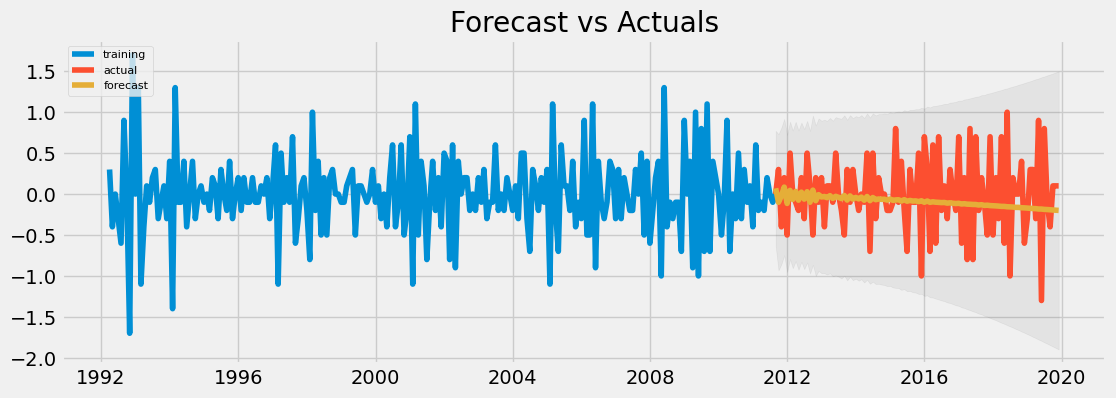

In [100]:
# running the model
model = ARIMA(train, order=(8, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(9, 2, 5)   Log Likelihood                 -84.268
Method:                       css-mle   S.D. of innovations              0.330
Date:                Sat, 09 Jul 2022   AIC                            200.536
Time:                        20:15:26   BIC                            255.684
Sample:                    05-31-1992   HQIC                           222.776
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.578e-07   2.84e-06      0.091      0.928    -5.3e-06    5.82e-06
ar.L1.D2.Value    -0.9994      0.106     -9.388      0.000      -1.208      -0.791
ar.L2.D2.Value    -0.7182        nan

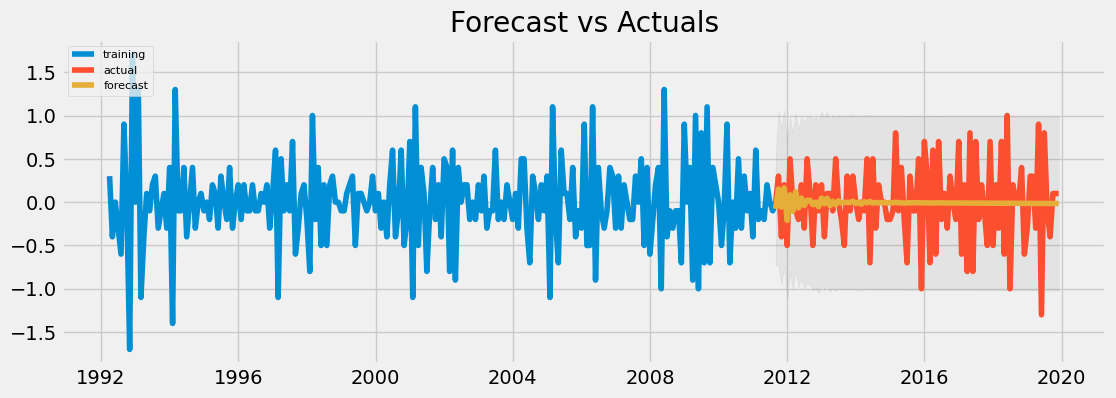

In [101]:
# running the model
model = ARIMA(train, order=(9, 2, 5))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(9, 2, 4)   Log Likelihood                -115.510
Method:                       css-mle   S.D. of innovations              0.388
Date:                Sat, 09 Jul 2022   AIC                            261.021
Time:                        20:19:58   BIC                            312.722
Sample:                    05-31-1992   HQIC                           281.871
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.464e-05   6.97e-05     -0.354      0.724      -0.000       0.000
ar.L1.D2.Value    -3.2747        nan        nan        nan         nan         nan
ar.L2.D2.Value    -5.6216        nan

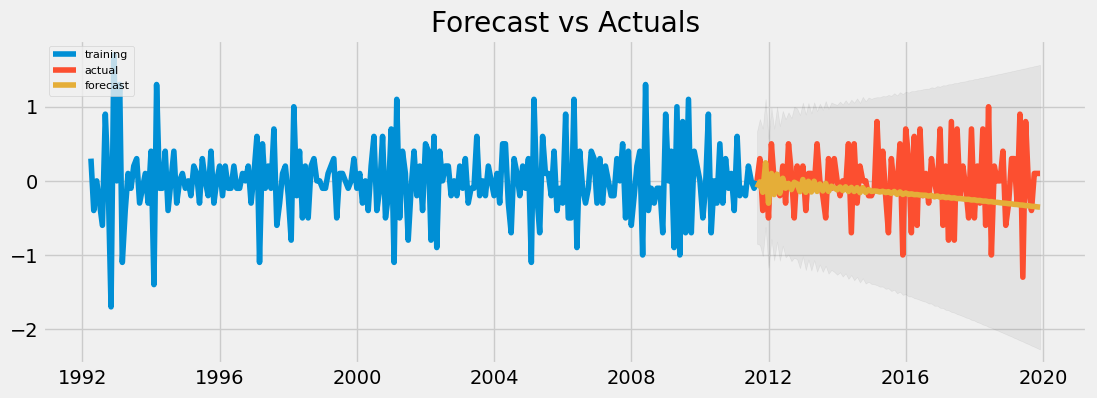

In [116]:
# running the model
model = ARIMA(train, order=(9, 2, 4))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(9, 2, 3)   Log Likelihood                -116.802
Method:                       css-mle   S.D. of innovations              0.390
Date:                Sat, 09 Jul 2022   AIC                            261.604
Time:                        20:20:24   BIC                            309.859
Sample:                    05-31-1992   HQIC                           281.065
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.832e-05      0.000     -0.253      0.800      -0.000       0.000
ar.L1.D2.Value    -3.1318      0.200    -15.642      0.000      -3.524      -2.739
ar.L2.D2.Value    -4.9778      0.541

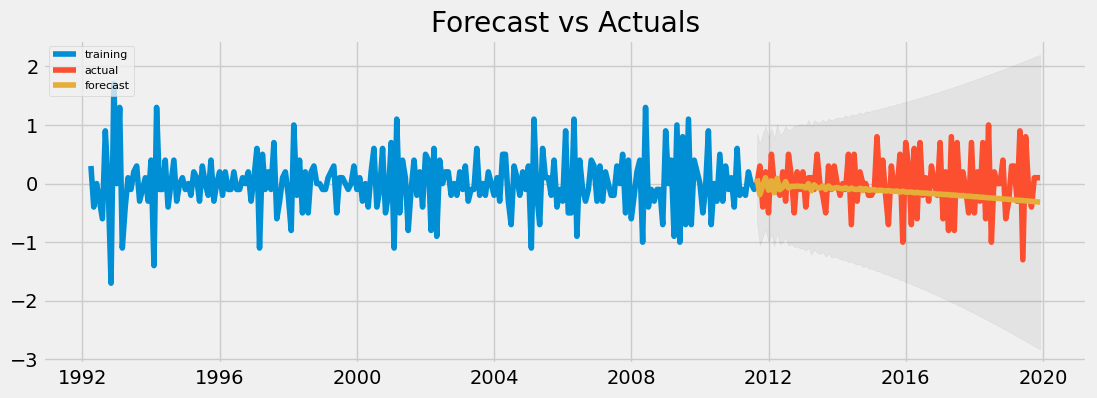

In [117]:
# running the model
model = ARIMA(train, order=(9, 2, 3))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D2.Value   No. Observations:                  232
Model:                 ARIMA(9, 2, 2)   Log Likelihood                -122.187
Method:                       css-mle   S.D. of innovations              0.399
Date:                Sat, 09 Jul 2022   AIC                            270.373
Time:                        20:22:13   BIC                            315.181
Sample:                    05-31-1992   HQIC                           288.444
                         - 08-31-2011                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -4.76e-05      0.000     -0.355      0.723      -0.000       0.000
ar.L1.D2.Value    -2.5796      0.069    -37.467      0.000      -2.714      -2.445
ar.L2.D2.Value    -3.4328      0.176

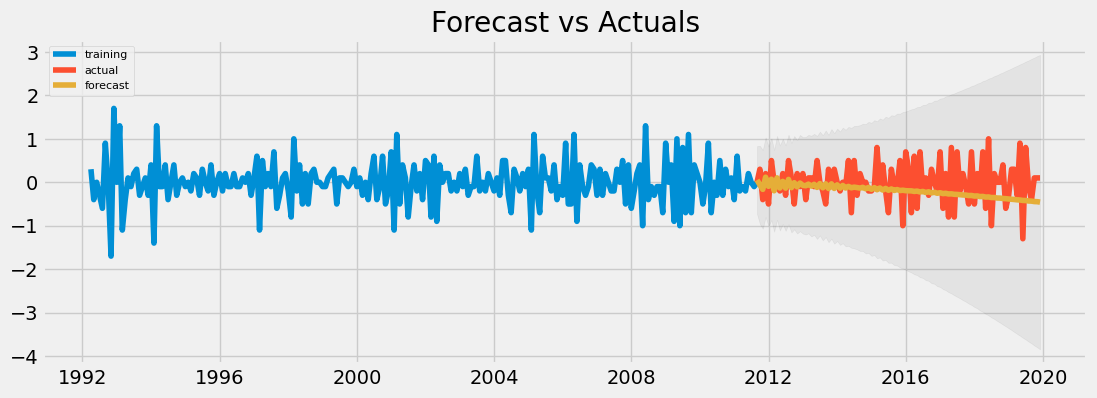

In [118]:
# running the model
model = ARIMA(train, order=(9, 2, 2))  
fitted = model.fit()  
print(fitted.summary())

fc, se, conf = fitted.forecast(100, alpha=0.05)

fc_series = pd.Series(fc, index=test.index) 
lower_series = pd.Series(conf[:, 0], index=test.index) 
upper_series = pd.Series(conf[:, 1], index=test.index) 

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### I think non of the tried models is a good fit for forecasting. I assume that the models of univariat forecasting for inflation are generally not a good fit.